In [1]:
from binance.client import Client as bnb_client 
from datetime import datetime 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt


/Users/shayonabasu/Documents/Personal/WSQ/quant_venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
client = bnb_client()
###  if you're in the US, use: 
### "client = bnb_client(tld='US')" here instead

def get_binance_px(symbol,freq,start_ts = '2024-01-01'):
    data = client.get_historical_klines(symbol,freq,start_ts)
    columns = ['open_time','open','high','low','close','volume','close_time','quote_volume',
    'num_trades','taker_base_volume','taker_quote_volume','ignore']

    data = pd.DataFrame(data,columns = columns)
    
    # Convert from POSIX timestamp (number of millisecond since jan 1, 1970)
    data['open_time'] = data['open_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    data['close_time'] = data['close_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    return data 

univ = ['BTCUSDT','ETHUSDT','ADAUSDT','BNBUSDT','XRPUSDT','DOTUSDT','MATICUSDT']

freq = '4h' #6 bars is 1 day
px = {}
for x in univ:
    data = get_binance_px(x,freq)
    px[x] = data.set_index('open_time')['close']

px = pd.DataFrame(px).astype(float)

#ensures all assets align in time
px = px.reindex(pd.date_range(px.index[0],px.index[-1],freq=freq))
ret = px.pct_change()

/var/folders/4x/krc40z7s7vj9v5ywpq9kg1th0000gn/T/ipykernel_90936/3323568171.py:29: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ret = px.pct_change()


In [51]:
ret

,BTCUSDT,ETHUSDT,ADAUSDT,BNBUSDT,XRPUSDT,DOTUSDT,MATICUSDT
2024-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-01 04:00:00,0.003826,0.004776,0.005876,0.004528,0.003263,0.002700,0.000000
2024-01-01 08:00:00,0.004654,0.008666,0.006677,-0.003542,0.008943,0.008568,0.021389
2024-01-01 12:00:00,0.002175,0.004439,0.004643,0.009693,0.001289,0.017233,0.007081
2024-01-01 16:00:00,0.017178,0.009746,0.020796,-0.002240,0.007243,0.025292,0.010447
...,...,...,...,...,...,...,...
2026-01-16 20:00:00,0.005777,0.005902,0.022492,0.007301,0.006229,0.012422,0.000000
2026-01-17 00:00:00,-0.001863,-0.002111,-0.002276,-0.000544,-0.005852,0.004719,0.000000
2026-01-17 04:00:00,-0.002844,0.000684,0.002534,-0.001866,0.001167,0.013152,0.000000
2026-01-17 08:00:00,0.002336,0.003387,-0.002022,0.007511,0.001846,0.012054,0.000000


Pairs Mean Reversion

“Altcoin A deviating from its historical price ratio with Altcoin B will revert to its mean ratio in the short term.”

Signal idea: rolling spread / z-score on pairs

In [52]:
strats = {}
for hor in [1,2,3,4,5,6]:
    avg_ret = ret.rolling(hor,min_periods=1).mean().rank(1)
    #market neutralization
    avg_ret = avg_ret.subtract(avg_ret.mean(1),0)
    avg_ret = avg_ret.divide(avg_ret.abs().sum(1),0)
    strats[hor] = (avg_ret.shift()*ret).sum(1)
strats = pd.DataFrame(strats)

In [53]:
sr = strats.mean()/strats.std()*np.sqrt(252*24/4)
sr = strats.resample('A').mean()/strats.resample('A').std()*np.sqrt(252*24/4)

/var/folders/4x/krc40z7s7vj9v5ywpq9kg1th0000gn/T/ipykernel_73019/2810684599.py:2: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  sr = strats.resample('A').mean()/strats.resample('A').std()*np.sqrt(252*24/4)


In [54]:
sr

,1,2,3,4,5,6
2024-12-31,-0.416236,-0.151561,0.432095,1.577342,1.765614,2.025395
2025-12-31,1.228317,0.457915,0.636662,0.997086,-0.010855,0.010185
2026-12-31,-0.391693,0.062628,2.357424,1.740101,1.067875,4.507318


In [55]:
strats_lag = {}
for hor in [1,2,3,4,5,6]:
    avg_ret = ret.rolling(hor,min_periods=1).mean().rank(1)
    avg_ret = avg_ret.subtract(avg_ret.mean(1),0)
    avg_ret = avg_ret.divide(avg_ret.abs().sum(1),0)
    strats_lag[hor] = (avg_ret.shift(2)*ret).sum(1)
strats_lag = pd.DataFrame(strats_lag)

In [56]:
sr_lag = strats_lag.mean()/strats_lag.std()*np.sqrt(252*24/4)
sr_lag

1   -0.069753
2    0.367335
3    1.321989
4    0.322889
5    0.566910
6    0.677476
dtype: float64

# Backtesting

In [57]:
ann_factor = np.sqrt(252 * 24 / 4)
sr = strats.mean()/ strats.std()* ann_factor
sr_lag = strats_lag.mean() / strats_lag.std() * ann_factor

# Rename columns to horizon labels
strats.columns = [f'{h} × 4h lookback' for h in strats.columns]
strats_lag.columns = [f'{h} × 4h lookback (lagged)' for h in strats_lag.columns]


In [58]:
pd.DataFrame({
    'no_lag': sr,
    'lag_2': sr_lag
})

,no_lag,lag_2
1,0.379635,-0.069753
2,0.156444,0.367335
3,0.573429,1.321989
4,1.291425,0.322889
5,0.858416,0.566910
6,1.066108,0.677476


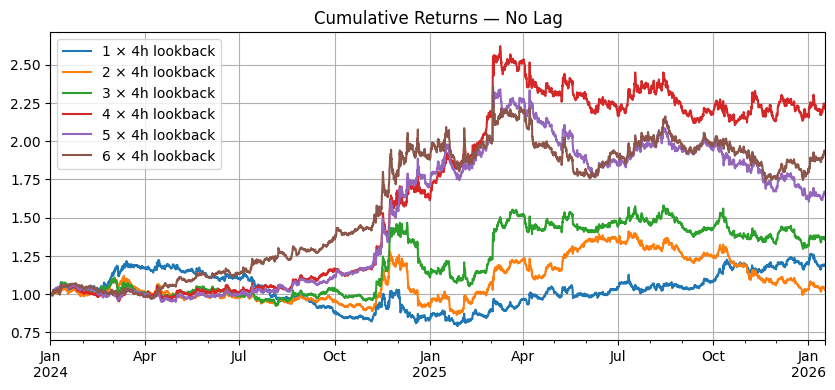

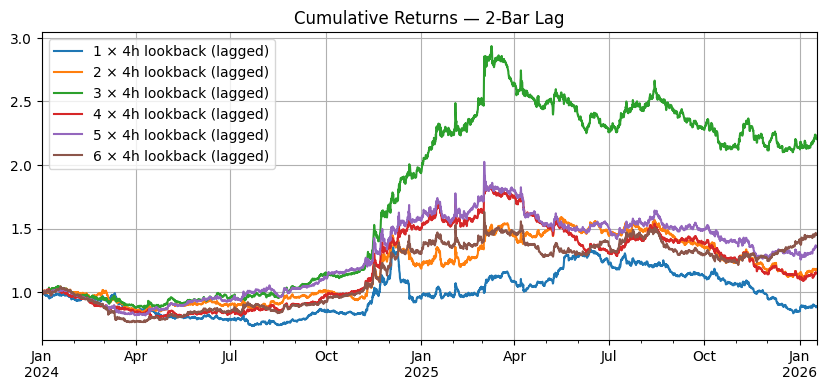

In [59]:
(1 + strats).cumprod().plot(
    figsize=(10,4),
    title='Cumulative Returns — No Lag'
)
plt.grid(True)
plt.show()

(1 + strats_lag).cumprod().plot(
    figsize=(10,4),
    title='Cumulative Returns — 2-Bar Lag'
)
plt.grid(True)
plt.show()


## Calculating Spread and Rolling Statistics

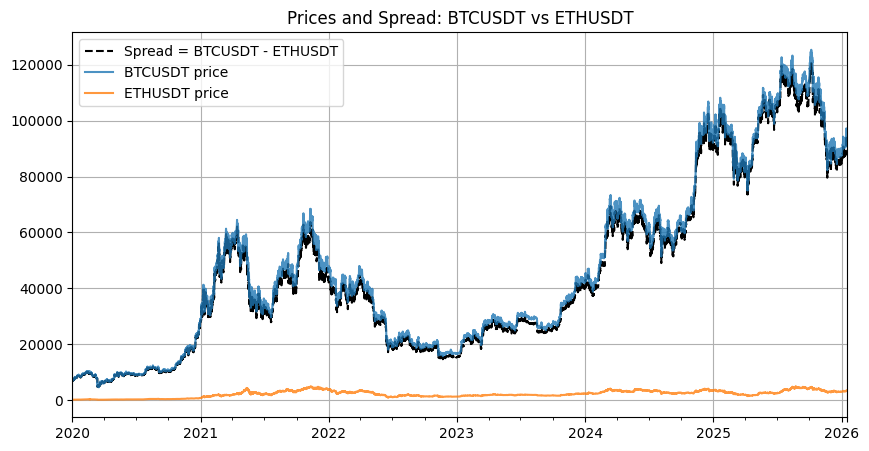

In [19]:
ticker_long = 'BTCUSDT'
ticker_short = 'ETHUSDT'

# Calculate spread
spread = px[ticker_long] - px[ticker_short]

# Parameters
window = 30
n_std = 1.5

# Rolling stats
rolling_mean = spread.rolling(window=window).mean()
rolling_std = spread.rolling(window=window).std()

# Z-score
zscore = (spread - rolling_mean) / rolling_std

upper_band = rolling_mean + n_std * rolling_std
lower_band = rolling_mean - n_std * rolling_std

figs = (10, 5)

plt.figure(figsize=figs)

spread.plot(
    label=f'Spread = {ticker_long} - {ticker_short}',
    linestyle='--',
    color='black'
)

px[ticker_long].plot(label=f'{ticker_long} price', alpha=0.8)
px[ticker_short].plot(label=f'{ticker_short} price', alpha=0.8)

plt.title(f"Prices and Spread: {ticker_long} vs {ticker_short}")
plt.legend()
plt.grid(True)
plt.show()


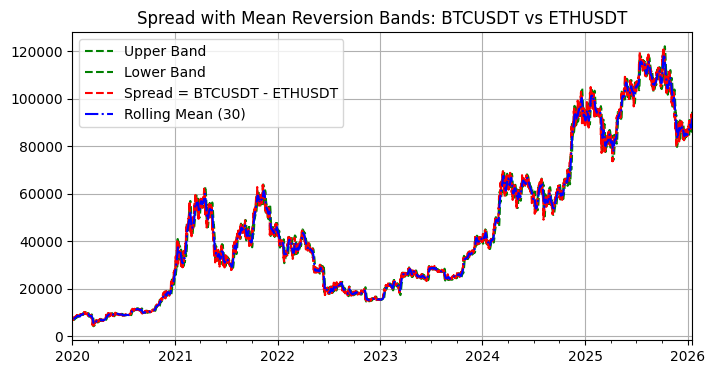

In [20]:
figs = (8, 4)
plt.figure(figsize=figs)

# Plot bands
upper_band.plot(label='Upper Band', linestyle='--', color='green')
lower_band.plot(label='Lower Band', linestyle='--', color='green')

# Plot spread and rolling mean
spread.plot(
    label=f'Spread = {ticker_long} - {ticker_short}',
    linestyle='--',
    color='red'
)
rolling_mean.plot(
    label='Rolling Mean (30)',
    linestyle='-.',
    color='blue'
)

# Fill between bands (IMPORTANT: use spread.index)
plt.fill_between(
    spread.index,
    lower_band,
    upper_band,
    alpha=0.2
)

plt.title(f"Spread with Mean Reversion Bands: {ticker_long} vs {ticker_short}")
plt.legend()
plt.grid(True)
plt.show()


/var/folders/4x/krc40z7s7vj9v5ywpq9kg1th0000gn/T/ipykernel_73019/1402065942.py:1: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pair_returns = px[ticker_long].pct_change() - px[ticker_short].pct_change()


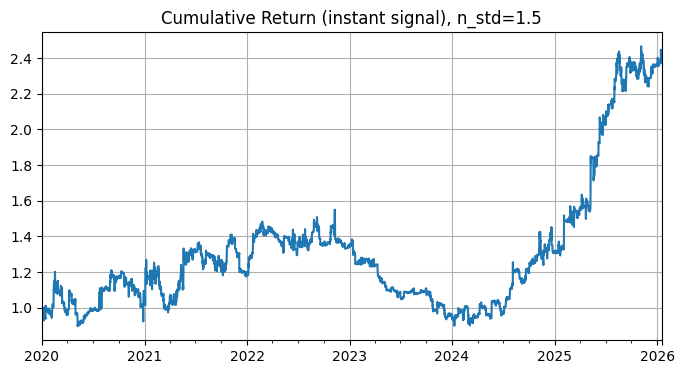

In [21]:
pair_returns = px[ticker_long].pct_change() - px[ticker_short].pct_change()
signal = np.where(zscore < -n_std, 1,
          np.where(zscore >  n_std, -1, 0))
signal = pd.Series(signal, index=zscore.index)

strategy_returns = signal.shift(1) * pair_returns
cumulative_returns = (1 + strategy_returns.fillna(0)).cumprod()

cumulative_returns.plot(figsize=figs)
plt.title(f"Cumulative Return (instant signal), n_std={n_std}")
plt.grid(True)
plt.show()


## 6 Month backtesting

In [ ]:
# same universe asset class
univ = ['BTCUSDT','ETHUSDT','ADAUSDT','BNBUSDT','XRPUSDT','DOTUSDT','MATICUSDT']

end = ret.index.max()
start = end - pd.DateOffset(months=6)

ret_6m = ret.loc[start:end, univ].copy()
px_6m  = px.loc[start:end, univ].copy()

ret_6m.index.min(), ret_6m.index.max()


(Timestamp('2025-07-18 08:00:00'), Timestamp('2026-01-18 08:00:00'))

In [10]:
#compute weights once per day 
day = ret_6m.index.floor("D")
is_rebal = day.to_series().shift(1).ne(day).fillna(True)
# boolean Series indexed by timestamps
is_rebal.value_counts()

False    920
True     185
Name: count, dtype: int64

In [11]:
#rebalance weights everyday and build vol-adjusted weights

vol_lookback = 42   # ~1 week of 4h bars
lag = 1             # execute next bar after signal (avoid lookahead)

bars_per_year = 365 * 24 / 4     # crypto annualization for 4h bars
ann_factor = np.sqrt(bars_per_year)


In [15]:
def make_daily_vol_adj_weights(ret_df, horizons=(1,2,3,4,5,6), vol_lb=42, lag=1):
    """
    Daily-rebalanced, volatility-adjusted cross-sectional weights.

    ret_df: DataFrame of returns (index timestamps, columns assets)
    horizons: lookback horizons in bars
    vol_lb: volatility lookback in bars
    lag: execution lag in bars
    """
    # --- Daily rebalance mask (boolean Series with SAME index as ret_df) ---
    day = ret_df.index.floor("D")
    is_rebal = day.to_series().shift(1).ne(day).fillna(True)
    is_rebal.index = ret_df.index  # force identical index object

    # Make it broadcastable to DataFrame shape
    rebal_mask = pd.DataFrame(
        np.repeat(is_rebal.to_numpy()[:, None], ret_df.shape[1], axis=1),
        index=ret_df.index,
        columns=ret_df.columns
    )

    # Rolling vol per asset
    vols = ret_df.rolling(vol_lb, min_periods=vol_lb).std().replace(0, np.nan)

    weights_by_h = {}

    for hor in horizons:
        # Signal: past avg returns over 'hor' bars, ranked cross-sectionally
        score = ret_df.rolling(hor, min_periods=hor).mean().rank(axis=1)

        # Dollar-neutralize
        score = score.sub(score.mean(axis=1), axis=0)

        # Inverse-vol scaling
        raw = score.div(vols, axis=0)

        # Normalize leverage to sum(abs(w)) = 1
        denom = raw.abs().sum(axis=1).replace(0, np.nan)
        w = raw.div(denom, axis=0)

        # Execution lag
        w = w.shift(lag)

        # Rebalance only once per day (set non-rebalance rows to NaN, then ffill)
        w = w.where(rebal_mask, np.nan).ffill().fillna(0.0)

        weights_by_h[hor] = w

    return weights_by_h


In [16]:
weights_by_h = make_daily_vol_adj_weights(ret_6m, horizons=(1,2,3,4,5,6), vol_lb=vol_lookback, lag=lag)

# check weights only change once per day for one horizon
h = 3
w = weights_by_h[h]
changes = w.diff().abs().sum(axis=1) > 0
print("Total weight-change timestamps:", changes.sum())
print("Total rebalance timestamps:", is_rebal.sum())  # from your outer cell


Total weight-change timestamps: 177
Total rebalance timestamps: 185


In [17]:
#backtest portfolio returns + compute Sharpe 

def backtest_from_weights(ret_df, w):
    # portfolio return each bar
    port_ret = (w * ret_df).sum(axis=1).fillna(0.0)
    return port_ret

port_rets = {}
for hor, w in weights_by_h.items():
    port_rets[hor] = backtest_from_weights(ret_6m, w)

port_rets = pd.DataFrame(port_rets)
port_rets.columns = [f'{h}×4h' for h in port_rets.columns]

# Sharpe for each horizon (6-month sample)
sr = port_rets.mean() / port_rets.std() * ann_factor
sr


1×4h    1.999712
2×4h    0.628822
3×4h    0.347126
4×4h   -0.194734
5×4h    0.254156
6×4h    1.748506
dtype: float64

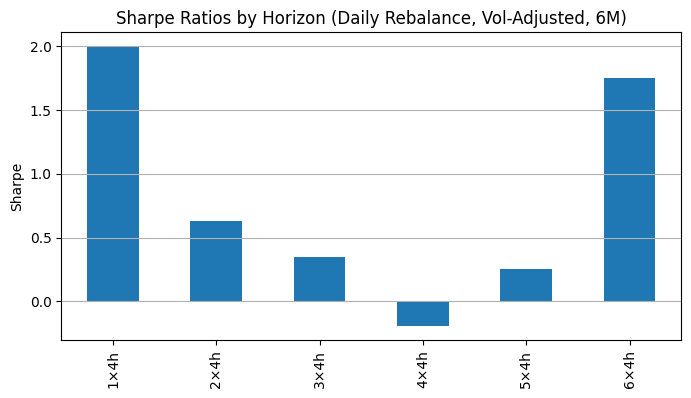

In [18]:
plt.figure(figsize=(8,4))
sr.plot(kind='bar')
plt.title(f"Sharpe Ratios by Horizon (Daily Rebalance, Vol-Adjusted, 6M)")
plt.ylabel("Sharpe")
plt.grid(True, axis='y')
plt.show()


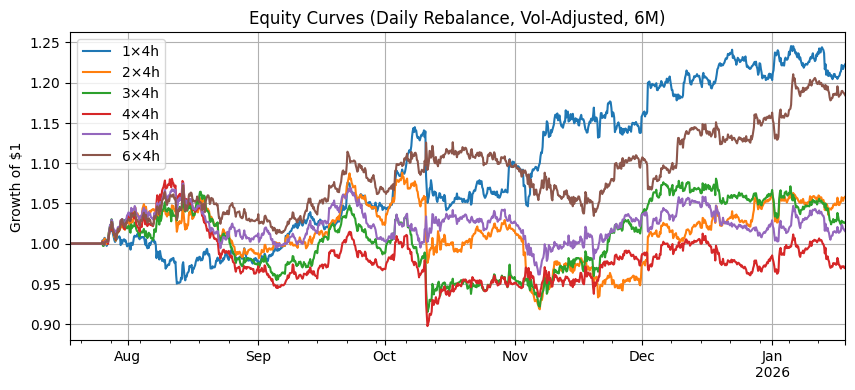

In [19]:
equity = (1 + port_rets.fillna(0)).cumprod()

equity.plot(figsize=(10,4))
plt.title("Equity Curves (Daily Rebalance, Vol-Adjusted, 6M)")
plt.ylabel("Growth of $1")
plt.grid(True)
plt.show()


In [20]:
asset_mean = ret_6m.mean()
asset_vol  = ret_6m.std()

asset_sharpe = asset_mean / asset_vol * ann_factor

asset_stats = pd.DataFrame({
    "mean_per_bar": asset_mean,
    "vol_per_bar": asset_vol,
    "sharpe_annualized": asset_sharpe
}).sort_values("sharpe_annualized", ascending=False)

asset_stats


,mean_per_bar,vol_per_bar,sharpe_annualized
BNBUSDT,0.000297,0.012207,1.137912
ETHUSDT,0.000019,0.013577,0.064888
BTCUSDT,-0.000170,0.008189,-0.972431
XRPUSDT,-0.000364,0.014296,-1.190718
DOTUSDT,-0.000485,0.018609,-1.218682
ADAUSDT,-0.000544,0.017497,-1.453846
MATICUSDT,0.000000,0.000000,NaN


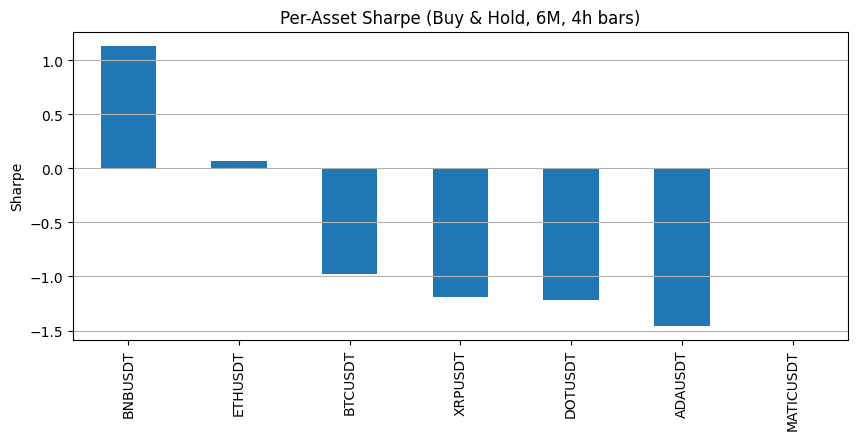

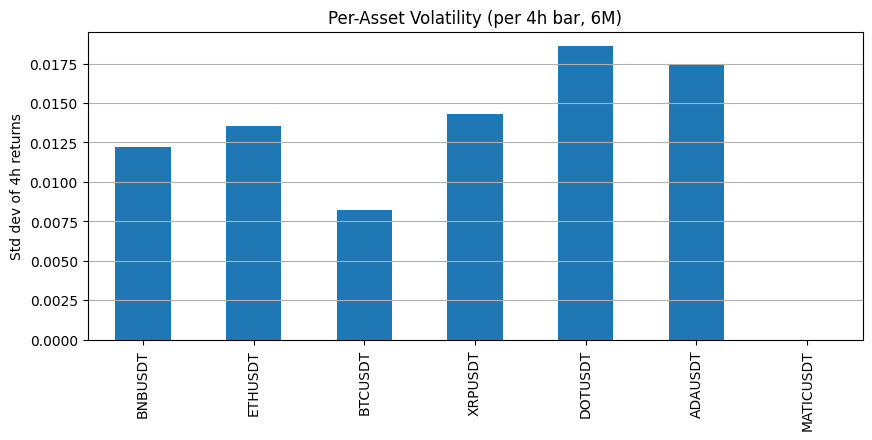

In [21]:
plt.figure(figsize=(10,4))
asset_stats["sharpe_annualized"].plot(kind='bar')
plt.title("Per-Asset Sharpe (Buy & Hold, 6M, 4h bars)")
plt.ylabel("Sharpe")
plt.grid(True, axis='y')
plt.show()

plt.figure(figsize=(10,4))
asset_stats["vol_per_bar"].plot(kind='bar')
plt.title("Per-Asset Volatility (per 4h bar, 6M)")
plt.ylabel("Std dev of 4h returns")
plt.grid(True, axis='y')
plt.show()


In [ ]:
h_show = 3

# select horizon + subset of assets
w_show = weights_by_h[h_show][['BTCUSDT', 'ETHUSDT', 'BNBUSDT']].copy()
w_show.columns = ['BTC', 'ETH', 'BNB']

# build daily rebalance mask safely
day = w_show.index.floor("D")
is_rebal = day.to_series().shift(1).ne(day).fillna(True)

# slice weights at rebalance timestamps
w_rebal = w_show.loc[is_rebal.values].round(3)

# each row shows a daily rebalance
w_rebal.tail(10)


,BTC,ETH,BNB
2026-01-09,0.183,-0.290,0.000
2026-01-10,0.243,-0.104,0.358
2026-01-11,0.159,0.000,0.427
2026-01-12,0.270,0.340,-0.118
2026-01-13,0.328,-0.282,0.193
2026-01-14,-0.361,0.128,-0.153
2026-01-15,0.413,0.104,0.244
2026-01-16,0.000,0.134,0.326
2026-01-17,0.000,-0.222,0.266
2026-01-18,-0.391,0.093,0.227


# Returns of a $1000 in Jan 2025 vs Jan 2026 using this model

In [25]:
start = '2025-01-01'
end   = '2026-01-01'

ret_2025 = ret.loc[start:end, univ]

weights_2025 = make_daily_vol_adj_weights(
    ret_2025,
    horizons=(3,),        
    vol_lb=vol_lookback,
    lag=lag
)[3]                      # horizon = 3 × 4h

port_ret_2025 = (weights_2025 * ret_2025).sum(axis=1).fillna(0.0)

init_capital = 1000.0

equity_2025 = init_capital * (1 + port_ret_2025).cumprod()

final_value = equity_2025.iloc[-1]
profit = final_value - init_capital

final_value, profit


(np.float64(1160.6893008912568), np.float64(160.68930089125683))

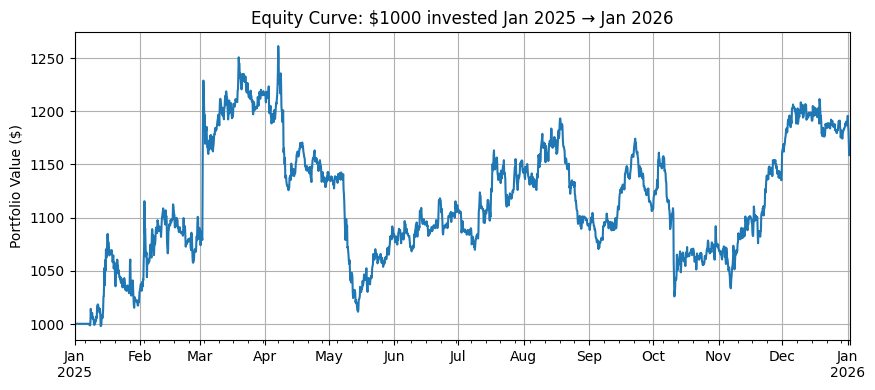

In [26]:
equity_2025.plot(figsize=(10,4))
plt.title("Equity Curve: $1000 invested Jan 2025 → Jan 2026")
plt.ylabel("Portfolio Value ($)")
plt.grid(True)
plt.show()


Did not include transaction costs and turnover penalties